In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class AdvancedHealthImpactScoreModel:
    def __init__(self, pollution_feature_dim, health_feature_dim):
        """
        Initialize Advanced Health Impact Score Model
        
        Args:
            pollution_feature_dim (int): Number of pollution features
            health_feature_dim (int): Number of health impact features
        """
        self.pollution_feature_dim = pollution_feature_dim
        self.health_feature_dim = health_feature_dim
        
        # Scalers
        self.pollution_scaler = StandardScaler()
        self.health_scaler = MinMaxScaler(feature_range=(0, 1))
        
        # Build model components
        self.model = self._build_multi_output_model()
        self._create_fuzzy_inference_system()
    
    def _create_fuzzy_inference_system(self):
        """
        Create advanced fuzzy logic inference system for health impact
        """
        # Fuzzy Input Variables
        self.pollution_risk = ctrl.Antecedent(np.linspace(0, 100, 100), 'pollution_risk')
        self.health_impact_score = ctrl.Antecedent(np.linspace(0, 100, 100), 'health_impact_score')
        
        # Fuzzy Output Variable
        self.health_hazard = ctrl.Consequent(np.linspace(0, 100, 100), 'health_hazard')
        
        # Membership Functions for Pollution Risk
        self.pollution_risk['low'] = fuzz.trimf(self.pollution_risk.universe, [0, 0, 30])
        self.pollution_risk['medium'] = fuzz.trimf(self.pollution_risk.universe, [20, 50, 80])
        self.pollution_risk['high'] = fuzz.trimf(self.pollution_risk.universe, [70, 100, 100])
        
        # Membership Functions for Health Impact Score
        self.health_impact_score['low'] = fuzz.trimf(self.health_impact_score.universe, [0, 0, 30])
        self.health_impact_score['medium'] = fuzz.trimf(self.health_impact_score.universe, [20, 50, 80])
        self.health_impact_score['high'] = fuzz.trimf(self.health_impact_score.universe, [70, 100, 100])
        
        # Membership Functions for Health Hazard
        self.health_hazard['safe'] = fuzz.trimf(self.health_hazard.universe, [0, 0, 30])
        self.health_hazard['moderate'] = fuzz.trimf(self.health_hazard.universe, [20, 50, 80])
        self.health_hazard['critical'] = fuzz.trimf(self.health_hazard.universe, [70, 100, 100])
        
        # Fuzzy Rules
        rules = [
            ctrl.Rule(
                self.pollution_risk['low'] & self.health_impact_score['low'], 
                self.health_hazard['safe']
            ),
            ctrl.Rule(
                self.pollution_risk['medium'] | self.health_impact_score['medium'], 
                self.health_hazard['moderate']
            ),
            ctrl.Rule(
                self.pollution_risk['high'] | self.health_impact_score['high'], 
                self.health_hazard['critical']
            )
        ]
        
        # Create Fuzzy Control System
        self.health_hazard_ctrl = ctrl.ControlSystem(rules)
        self.health_hazard_simulation = ctrl.ControlSystemSimulation(self.health_hazard_ctrl)
    
    def _build_multi_output_model(self):
        """
        Build neural network with multiple outputs
        """
        # Pollution Inputs
        pollution_inputs = Input(shape=(self.pollution_feature_dim,), name='pollution_inputs')
        
        # Health Impact Inputs
        health_inputs = Input(shape=(self.health_feature_dim,), name='health_inputs')
        
        # Feature Processing
        x_pollution = Dense(64, activation='relu')(pollution_inputs)
        x_pollution = Dropout(0.3)(x_pollution)
        
        x_health = Dense(32, activation='relu')(health_inputs)
        x_health = Dropout(0.2)(x_health)
        
        # Concatenate Features
        combined = Concatenate()([x_pollution, x_health])
        
        # Advanced Hidden Layers
        x = Dense(64, activation='relu')(combined)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        
        # Multiple Outputs
        # Binary Classification Output
        binary_classification = Dense(1, activation='sigmoid', name='binary_health_class')(x)
        
        # Continuous Health Impact Score Regression Output
        health_impact_score = Dense(1, activation='linear', name='health_impact_score')(x)
        
        # Uncertainty Estimation
        uncertainty = Lambda(
            lambda tensor: tf.math.reduce_std(tensor, axis=-1), 
            name='uncertainty'
        )(x)
        
        # Create Model
        model = Model(
            inputs=[pollution_inputs, health_inputs], 
            outputs=[binary_classification, health_impact_score, uncertainty]
        )
        
        # Compile Model with Multiple Losses
        model.compile(
            optimizer='adam',
            loss={
                'binary_health_class': 'binary_crossentropy',
                'health_impact_score': 'mean_squared_error',
                'uncertainty': 'mean_squared_error'
            },
            loss_weights={
                'binary_health_class': 1.0,
                'health_impact_score': 0.5,
                'uncertainty': 0.1
            },
            metrics={
                'binary_health_class': ['accuracy']
            }
        )
        
        return model
    
    def train(self, X_pollution, X_health, y_binary, y_score, epochs=100):
        """
        Train the multi-output health impact model
        
        Args:
            X_pollution (np.ndarray): Pollution features
            X_health (np.ndarray): Health impact features
            y_binary (np.ndarray): Binary health class
            y_score (np.ndarray): Continuous health impact score
            epochs (int): Number of training epochs
        """
        # Scale inputs
        X_pollution_scaled = self.pollution_scaler.fit_transform(X_pollution)
        X_health_scaled = self.health_scaler.fit_transform(X_health)
        
        # Simulate uncertainty
        uncertainty = np.random.random(len(y_binary))
        
        # Train model
        history = self.model.fit(
            [X_pollution_scaled, X_health_scaled], 
            {
                'binary_health_class': y_binary,
                'health_impact_score': y_score,
                'uncertainty': uncertainty
            },
            epochs=epochs,
            validation_split=0.2,
            verbose=1
        )
        
        return history
    
    def evaluate(self, X_pollution, X_health, y_binary, y_score):
        """
        Evaluate model performance
        
        Args:
            X_pollution (np.ndarray): Test pollution features
            X_health (np.ndarray): Test health impact features
            y_binary (np.ndarray): True binary health class
            y_score (np.ndarray): True health impact score
        """
        # Scale inputs
        X_pollution_scaled = self.pollution_scaler.transform(X_pollution)
        X_health_scaled = self.health_scaler.transform(X_health)
        
        # Predict
        y_pred_binary, y_pred_score, uncertainty = self.model.predict(
            [X_pollution_scaled, X_health_scaled]
        )
        
        # Binary Classification Evaluation
        y_pred_binary_class = (y_pred_binary > 0.5).astype(int)
        print("\nBinary Classification Report:")
        print(classification_report(y_binary, y_pred_binary_class))
        
        # Confusion Matrix
        cm = confusion_matrix(y_binary, y_pred_binary_class)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Regression Evaluation
        mse = mean_squared_error(y_score, y_pred_score)
        print("\nHealth Impact Score Regression:")
        print(f"Mean Squared Error: {mse}")
        
        # Scatter plot of true vs predicted scores
        plt.figure(figsize=(10, 6))
        plt.scatter(y_score, y_pred_score)
        plt.plot([y_score.min(), y_score.max()], [y_score.min(), y_score.max()], 'r--', lw=2)
        plt.title('True vs Predicted Health Impact Scores')
        plt.xlabel('True Scores')
        plt.ylabel('Predicted Scores')
        plt.show()
    
    def predict_health_impact(self, X_pollution, X_health):
        """
        Predict health impact with fuzzy uncertainty interpretation
        
        Args:
            X_pollution (np.ndarray): Pollution features
            X_health (np.ndarray): Health impact features
        
        Returns:
            dict: Prediction results with fuzzy interpretation
        """
        # Scale inputs
        X_pollution_scaled = self.pollution_scaler.transform(X_pollution)
        X_health_scaled = self.health_scaler.transform(X_health)
        
        # Predict
        binary_class, health_score, uncertainty = self.model.predict(
            [X_pollution_scaled, X_health_scaled]
        )
        
        # Fuzzy Uncertainty Interpretation
        self.health_hazard_simulation.input['pollution_risk'] = X_pollution_scaled[0][0] * 100
        self.health_hazard_simulation.input['health_impact_score'] = health_score[0][0] * 100
        self.health_hazard_simulation.compute()
        
        return {
            'binary_health_class': binary_class[0][0],
            'health_impact_score': health_score[0][0],
            'uncertainty': uncertainty[0],
            'fuzzy_health_hazard': self.health_hazard_simulation.output['health_hazard']
        }

In [4]:
 # Set random seed for reproducibility
np.random.seed(42)
    
# Generate synthetic dataset
n_samples = 1000

In [5]:
# Pollution Features
pollution_features = {
    'AQI': np.random.uniform(0, 500, n_samples),
    'PM10': np.random.uniform(0, 100, n_samples),
    'PM2_5': np.random.uniform(0, 50, n_samples),
    'NO2': np.random.uniform(0, 200, n_samples),
    'SO2': np.random.uniform(0, 100, n_samples),
    'O3': np.random.uniform(0, 100, n_samples)
}

In [6]:
# Health Impact Features
health_features = {
    'RespiratoryCases': np.random.uniform(0, 100, n_samples),
    'CardiovascularCases': np.random.uniform(0, 50, n_samples),
    'HospitalAdmissions': np.random.uniform(0, 30, n_samples)
}

In [7]:
 # Create DataFrames
df_pollution = pd.DataFrame(pollution_features)
df_health = pd.DataFrame(health_features)

# Compute Health Impact Score (0-100)
df_health['HealthImpactScore'] = (
    df_health['RespiratoryCases'] + 
    df_health['CardiovascularCases'] * 2 + 
    df_health['HospitalAdmissions'] * 3
) / (100 + 50 * 2 + 30 * 3) * 100

# Binary Health Impact Class (based on score threshold)
df_health['HealthImpactClass'] = (df_health['HealthImpactScore'] > 50).astype(int)

In [8]:
# Prepare data
X_pollution = df_pollution.values
X_health = df_health[['RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions']].values
y_binary = df_health['HealthImpactClass'].values
y_score = df_health['HealthImpactScore'].values

In [9]:
# Split data
X_pollution_train, X_pollution_test, \
X_health_train, X_health_test, \
y_binary_train, y_binary_test, \
y_score_train, y_score_test = train_test_split(
    X_pollution, X_health, y_binary, y_score, 
    test_size=0.2
)

In [10]:
# Initialize and train model
model = AdvancedHealthImpactScoreModel(
    pollution_feature_dim=6, 
    health_feature_dim=3
)

In [11]:
# Train model
history = model.train(
    X_pollution_train, 
    X_health_train, 
    y_binary_train, 
    y_score_train
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - binary_health_class_accuracy: 0.5261 - loss: 1325.6677 - val_binary_health_class_accuracy: 0.5312 - val_loss: 1284.2988
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_health_class_accuracy: 0.5020 - loss: 1244.7856 - val_binary_health_class_accuracy: 0.5312 - val_loss: 1082.7765
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_health_class_accuracy: 0.5193 - loss: 911.7028 - val_binary_health_class_accuracy: 0.5312 - val_loss: 568.7362
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_health_class_accuracy: 0.5289 - loss: 436.3500 - val_binary_health_class_accuracy: 0.5312 - val_loss: 91.8972
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_health_class_accuracy: 0.5351 - loss: 138.0157 - val_binary_health_class_accuracy: 0.4812 - val_loss: 80.1075
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_health_class_accuracy: 0.4917 - loss: 131.8249 - val_binary_health_class_accuracy:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Binary Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.61      0.76       106
           1       0.70      1.00      0.82        94

    accuracy                           0.80       200
   macro avg       0.85      0.81      0.79       200
weighted avg       0.86      0.80      0.79       200



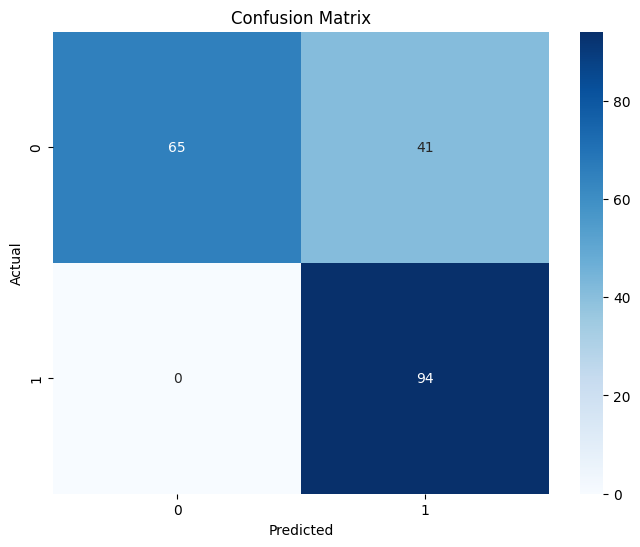


Health Impact Score Regression:
Mean Squared Error: 10.714456455934428


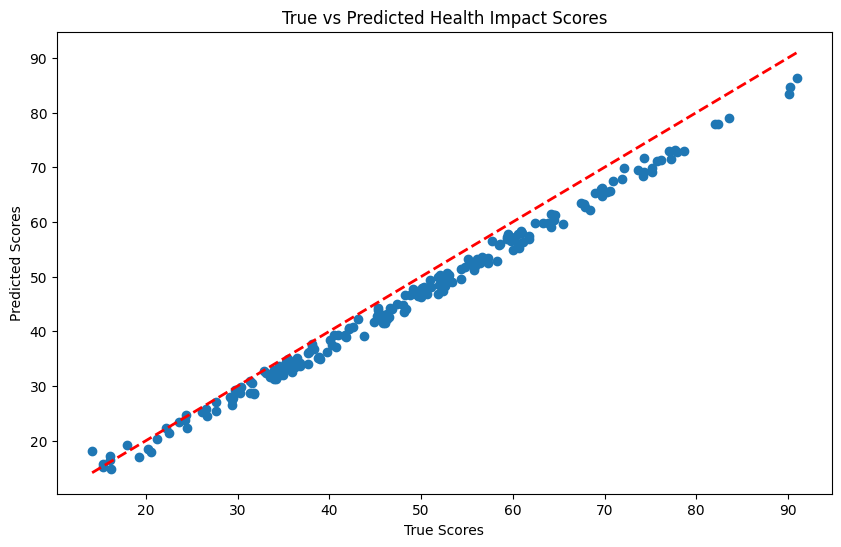

In [12]:
# Evaluate model
model.evaluate(
    X_pollution_test, 
    X_health_test, 
    y_binary_test, 
    y_score_test
)

In [13]:
# Predict and interpret results
print("\nHealth Impact Predictions:")
for i in range(5):
    prediction = model.predict_health_impact(
        X_pollution_test[i:i+1], 
        X_health_test[i:i+1]
    )
    print(f"\nPrediction {i+1}:")
    for key, value in prediction.items():
        print(f"{key}: {value}")


Health Impact Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Prediction 1:
binary_health_class: 0.4628640115261078
health_impact_score: 32.5800895690918
uncertainty: 2.744311571121216
fuzzy_health_hazard: 89.99527177017828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Prediction 2:
binary_health_class: 0.34904366731643677
health_impact_score: 17.24576759338379
uncertainty: 1.432207703590393
fuzzy_health_hazard: 89.99527177017828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Prediction 3:
binary_health_class: 0.47350794076919556
health_impact_score: 33.69971466064453
uncertainty: 2.8471267223358154
fuzzy_health_hazard: 89.99527177017828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Prediction 4:
binary_health_class: 0.7161834239959717
health_impact_score: 65.65045166015625
uncertainty: 5.591907024383545
fuzzy_health_hazard: 89.99527177017828
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Prediction 5:
binary_health_class: 0.605554461479187
health_impact_score: 49.62898254394531
uncertainty: 4.216858386993408
